In [0]:
import pandas as pd
import numpy as np
import re
import time
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
warnings.filterwarnings(action = 'ignore') 


In [5]:
las_vegas_data= pd.read_pickle('/content/drive/My Drive/las_vegas_data_tokenized.pkl')
las_vegas_data

,business_id,review_id,stars,text,tokenized_text,label,polarity
0,tstimHoMcYbkSC4eBA1wEg,iWFBGYotfzwiLsOka0e1Rw,4.5,we found out about this gem from the mans cowo...,"[found, gem, man, coworker, used, live, apt, c...",positive,0.238242
1,tstimHoMcYbkSC4eBA1wEg,QhiVo4F8MFSoz1T7YggcXA,4.5,the chips are a fried corn tortilla which were...,"[chip, fried, corn, tortilla, surprisingly, am...",positive,0.342857
2,tstimHoMcYbkSC4eBA1wEg,FUv-c5CkLy71yFTGLrp2ag,4.5,the pollo mole is well worth the trip out here...,"[pollo, mole, well, worth, trip, service, frie...",positive,0.377083
3,tstimHoMcYbkSC4eBA1wEg,lJfGtkCc4in6Xcq-_Wtfwg,4.5,ive ordered caldo de rez from here twice and b...,"[ive, ordered, caldo, de, rez, twice, time, fo...",positive,0.109524
4,tstimHoMcYbkSC4eBA1wEg,BKoH9aG1ZjUjy2brzkxzJw,4.5,my boyfriend doesnt like mexican food yet he l...,"[boyfriend, doesnt, like, mexican, food, yet, ...",positive,0.245631
...,...,...,...,...,...,...,...
712589,p5rpYtxS5xPQjt3MXYVEwA,M5Z6ju1IxgXyHbuTB4b0Ew,4.0,weak to say the least nobody knows whats going...,"[weak, say, least, nobody, know, whats, going,...",positive,-0.229167
712590,p5rpYtxS5xPQjt3MXYVEwA,pn5TS8GiEs0iE_O1dTkWuQ,4.0,i ordered the chicken quinoa salad i cant beli...,"[ordered, chicken, quinoa, salad, cant, believ...",positive,0.257778
712591,p5rpYtxS5xPQjt3MXYVEwA,ACUg1ScLb6pwL6jJyp65-w,4.0,i love this place salmon with steamed asparagu...,"[love, place, salmon, steamed, asparagus, brow...",positive,0.471875
712592,p5rpYtxS5xPQjt3MXYVEwA,_51tDhnA8WJY8VmUg1Cu6w,4.0,this is my go to spot when im too lazy to find...,"[go, spot, im, lazy, find, food, food, smoothy...",positive,0.173333


In [7]:
start= time.time()
vector = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer= vector.fit_transform(las_vegas_data['tokenized_text'])
print("Time to load data: {} seconds".format(time.time() - start))
# vectorizer.vocabulary_
# len(vectorizer.vocabulary_)

Time to load data: 26.239797353744507 seconds


In [0]:
vector.get_feature_names()

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.svm import LinearSVC
scores= pd.DataFrame()

C= [0.1,1,10,100,1000]
X=vectorizer
y=las_vegas_data['label']
dict_accuracy = {}
# dict_roc ={}

start= time.time()
for c in C:
  dict_accuracy[c] = []
  # dict_roc[c] = []
  print('Started for C=',c)
  svm = LinearSVC(dual=False, max_iter=10000, C=c).fit(X, y)
  print('Finished Modeling for C=',c)
  acc_scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy') 
  # roc_scores = cross_val_score(svm, X, y, cv=5, scoring='f1_macro')
  dict_accuracy[c].append(acc_scores)
  # roc_scores[c].append(roc_scores)
  print('Stored c and scores for C=',c)
  print('Finished for C=', c)

print("Time to load data: {} seconds".format(time.time() - start))

Started for C= 0.1
Finished Modeling for C= 0.1
Stored c and scores for C= 0.1
Finished for C= 0.1
Started for C= 1
Finished Modeling for C= 1
Stored c and scores for C= 1
Finished for C= 1
Started for C= 10
Finished Modeling for C= 10
Stored c and scores for C= 10
Finished for C= 10
Started for C= 100
Finished Modeling for C= 100
Stored c and scores for C= 100
Finished for C= 100
Time to load data: 1591.330164194107 seconds


In [34]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dict_accuracy_pca = {}
dict_accuracy_pca = {}
X=vectorizer
y=las_vegas_data['label']

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42).fit(X)

start= time.time()
for components in range(1,5):
  print('Started for Component=',components)
  reducedX = svd.transform((X))
  print('Finished PCA for Component=',components)
  dict_accuracy_pca[components] =[]
  svm_pca = LinearSVC(dual=False, max_iter=10000).fit(reducedX, y)
  print('Finished modelling for Component=',components)
  scores_pca = cross_val_score(svm_pca, reducedX, y,cv=5, scoring='accuracy')
  print('Stored component and scores for Component=',components)
  dict_accuracy_pca[components].append(scores_pca)
  print('Finished for Component=',components)

print("Time to load data: {} seconds".format(time.time() - start))

Started for Component= 1
Finished PCA for Component= 1
Finished modelling for Component= 1
Stored component and scores for Component= 1
Finished for Component= 1
Started for Component= 2
Finished PCA for Component= 2
Finished modelling for Component= 2
Stored component and scores for Component= 2
Finished for Component= 2
Started for Component= 3
Finished PCA for Component= 3
Finished modelling for Component= 3
Stored component and scores for Component= 3
Finished for Component= 3
Started for Component= 4
Finished PCA for Component= 4
Finished modelling for Component= 4
Stored component and scores for Component= 4
Finished for Component= 4
Time to load data: 47.33081126213074 seconds


In [36]:
dict_accuracy_pca

{1: [array([0.95542016, 0.95542016, 0.95541985, 0.95541985, 0.95541985])],
 2: [array([0.95542016, 0.95542016, 0.95541985, 0.95541985, 0.95541985])],
 3: [array([0.95542016, 0.95542016, 0.95541985, 0.95541985, 0.95541985])],
 4: [array([0.95542016, 0.95542016, 0.95541985, 0.95541985, 0.95541985])]}

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
# ax2 = ax.twinx()
for c, x in dict_accuracy.items(): 
    non_avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy.items()}
    pca_avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy_pca.items()}
    acc_list = sorted(non_avg_score.items())
    pca_list = sorted(pca_avg_score.items())
    x_plot, y_plot = zip(*acc_list)
    x, y = zip(*pca_list)
    ax.plot(x_plot, y_plot, color='orange',marker='d',markersize=10)
    ax.plot(x, y, color='green',marker='d',markersize=10)
plt.subplot(1, 2, 1)
ax.set_ylabel('Accuracy',fontsize=10)
ax.legend(['Accuracy'],loc='upper right',fontsize=15)
ax.set_xlabel('C- values',fontsize=10)
plt.subplot(1, 2, 2)
ax.set_ylabel('ROC AUC Score',fontsize=10)
ax.legend(['Roc- Auc'],loc='upper right',fontsize=15)
ax.set_xlabel('C- values',fontsize=10)
plt.title("Accuracy score vs C- values without PCA")
ax.set_xscale('log')
plt.show()


In [0]:
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['orange' if c < 0 else 'green' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

ValueError: ignored

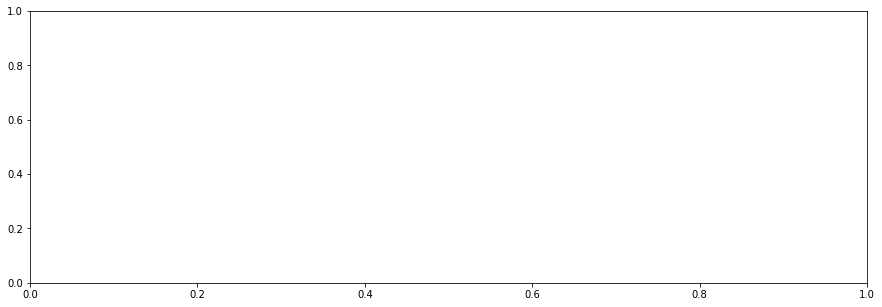

In [31]:
plot_coefficients(svm_pca, vector.get_feature_names())
# las_vegas_coefs= pd.DataFrame({'score': svm.coef_[0], 'words': vector.get_feature_names()})
# las_vegas_coefs.set_index('words', inplace=True)
# las_vegas_coefs= las_vegas_coefs.sort_values(by='score', ascending=False)

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
for c, x in dict_accuracy_pca.items(): 
    avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy_pca.items()}
    list = sorted(avg_score.items())
    x_plot, y_plot = zip(*list)
    ax.plot(x_plot, y_plot, color='orange',marker='d',markersize=10)

ax.set_ylabel('Accuracy',fontsize=10)
ax.legend(['Accuracy'],loc='upper right',fontsize=15)
ax.set_xlabel('Component- values',fontsize=10)
plt.title("Accuracy vs Component- values with PCA")
ax.set_xscale('log')
plt.show()